# Setup

In [1]:
import numpy as np
import torch
import torch.autograd as autograd

# For the Gaussian process regression
import gpytorch
from gpytorch.models import ExactGP
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, MaternKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood

# For the optimization
import cyipopt
from cyipopt import Problem

# For the NTR
from scipy.spatial import ConvexHull

# For hermite quadrature
from itertools import product, combinations
from numpy.polynomial.hermite import hermgauss

# Plotting
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import matplotx
import mplcyberpunk
from aquarel import load_theme
import vapeplot
import logging
from joblib import Parallel, delayed
import os

# Set up logging configuration
logging.basicConfig(filename='optimization_log.txt', 
                    filemode='w',
                    level=logging.INFO, 
                    format='%(asctime)s - %(levelname)s - %(message)s')

# Set random seed for reproducibility
np.random.seed(12102001)
torch.manual_seed(12102001)

# matplotx.styles.duftify(matplotx.styles.dracula)
# plt.style.use("cyberpunk")
# theme = load_theme("arctic_light")
# theme = load_theme("scientific")
# theme = load_theme("umbra_dark")
# theme.apply()

# vapeplot.set_palette('jazzcup')
# plt.style.use(matplotx.styles.dracula)
vapeplot.set_palette('macplus')

torch.set_printoptions(sci_mode=False, precision=4)
np.set_printoptions(suppress=True,precision=4)

# Parameters
T = 8  # Time horizon
D = 2  # Number of risky assets
r = 0.02  # Risk-free return in pct.
Rf = np.exp(r)  # Risk-free return
tau = 0.0225  # Transaction cost rate
# tau = 0.0  # Transaction cost rate
beta = 0.975  # Discount factor
gamma = 3.5  # Risk aversion coefficient

# Include consumption flag
include_consumption = False  # Set to True to include consumption

# Parameters
N = 250  # Number of sample points for the Value function surrogate
k = 150 # number of sample points for the historic returns

# Risky assets
# Drift (mean log-returns)
mu = np.array([0.06, 0.06])  # Assume both assets have the same drift

# Volatilities (standard deviation of log-returns)
sigma = np.array([0.2, 0.2])  # Different volatilities for assets

# Correlation matrix of the log-returns
Correlation_Matrix = np.array([[1.0, 0.0],   # Correlation of 0.0 between assets
                  [0.0, 1.0]])

Sigma = np.diag(sigma) @ Correlation_Matrix @ np.diag(sigma) #= array([[0.04, 0.  ],[0.  , 0.04]])
Sigma = np.diag(sigma**(1/2)) @ Correlation_Matrix @ np.diag(sigma**(1/2)) #array([[0.2, 0.  ],[0.  , 0.2]])
print(Sigma)

[[0.2 0. ]
 [0.  0.2]]


# Simulate returns and train gp model for expectation

Empirical mean of log-returns:  [0.0465 0.0213]
Empirical covariance of log-returns: 
 [[0.1918 0.0066]
 [0.0066 0.1749]]
Empirical mean of returns:  [1.1533 1.112 ]
Empirical covariance of returns: 
 [[0.2894 0.0086]
 [0.0086 0.2227]]


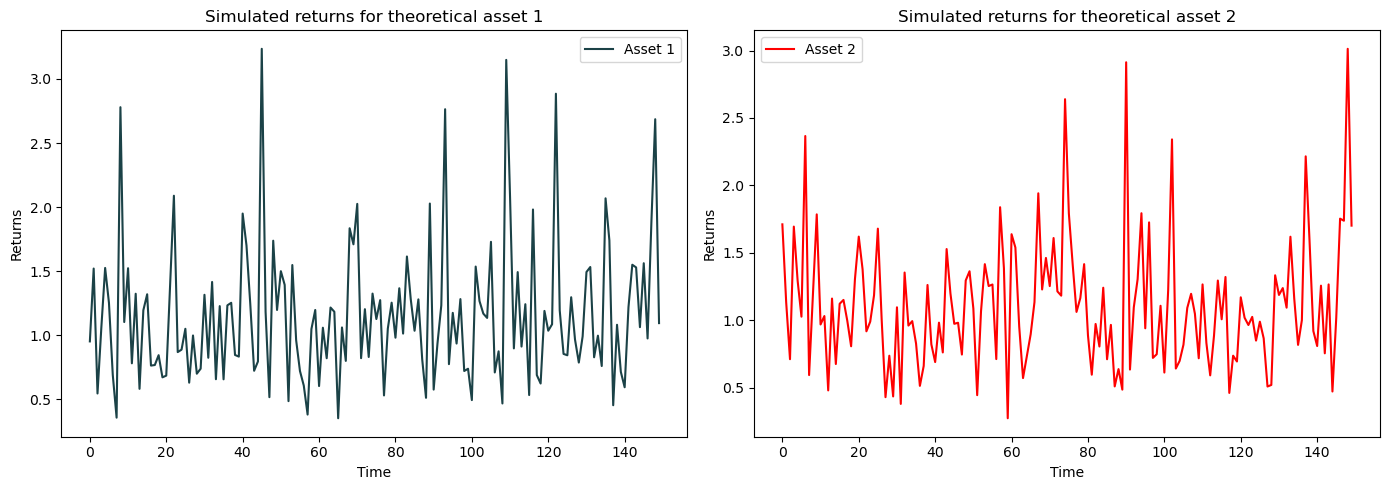

In [2]:
# Generate Simulated Log-Returns (similar to the structure you had)
def simulate_returns(mu, sigma, Sigma, num_data_points=364):
    """
    Simulates log-returns and returns based on the given parameters.

    Args:
        mu (np.ndarray): 1D array of mean log-returns.
        sigma (np.ndarray): 1D array of standard deviations of log-returns.
        Sigma (np.ndarray): 2D correlation matrix of log-returns.
        num_data_points (int): Number of time periods to simulate.

    Returns:
        tuple: Tuple containing:
            - log_returns (np.ndarray): Simulated log-returns.
            - returns (np.ndarray): Simulated returns.
    """
    # Construct covariance matrix    
    # Ensure the covariance matrix is positive definite
    try:
        L = np.linalg.cholesky(Sigma)
    except np.linalg.LinAlgError:
        # Add a small jitter to the diagonal for numerical stability
        jitter = 1e-6
        Sigma += np.eye(Sigma.shape[0]) * jitter
        L = np.linalg.cholesky(Sigma)
        print(f"Added jitter to covariance matrix for Cholesky decomposition: {jitter}")
    
    # Generate independent standard normal variables
    z = np.random.normal(size=(num_data_points, len(mu)))
    
    # Initialize log-returns array
    log_returns = np.zeros((num_data_points, len(mu)))
    
    for t in range(num_data_points):
        # Generate correlated shocks
        correlated_shocks = L @ z[t]
        # Compute log-returns
        log_returns[t] = mu - 0.5 * sigma**2 + correlated_shocks
    
    # Exponentiate to get returns
    returns = np.exp(log_returns)
    return log_returns, returns

log_returns , returns = simulate_returns(mu, sigma, Sigma, num_data_points=k)

# Verify the mean and covariance of the log-returns
print("Empirical mean of log-returns: ", np.mean(log_returns, axis=0))
print("Empirical covariance of log-returns: \n", np.cov(log_returns.T))

# Verify the mean and covariance of the log-normal returns (this won't match the log-returns directly)
print("Empirical mean of returns: ", np.mean(returns, axis=0))
print("Empirical covariance of returns: \n", np.cov(returns.T))


# Output mean and covariance
# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Plot for Asset 1
axs[0].plot(returns[:, 0], label='Asset 1')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Returns')
axs[0].set_title('Simulated returns for theoretical asset 1')
axs[0].legend()

# Plot for Asset 2 with a different color
axs[1].plot(returns[:, 1], label='Asset 2', color='red')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Returns')
axs[1].set_title('Simulated returns for theoretical asset 2')
axs[1].legend()
plt.tight_layout()
# theme.apply_transforms()
plt.show()

## Check of the quadrature

In [3]:
# Parameters
D = len(mu)  # Number of assets
n_q = 11  # Number of quadrature points per dimension

# Compute Gauss-Hermite nodes and weights for standard normal distribution
gh_nodes, gh_weights = np.polynomial.hermite.hermgauss(n_q)
gh_nodes = torch.tensor(gh_nodes, dtype=torch.float32)
gh_weights = torch.tensor(gh_weights, dtype=torch.float32)

# Convert mu and Sigma to tensors
mu_tensor = torch.tensor(mu, dtype=torch.float32)  # Shape: [D]
Sigma_tensor = torch.tensor(Sigma, dtype=torch.float32)  # Shape: [D, D]

# Perform Cholesky decomposition of Sigma
L = torch.linalg.cholesky(Sigma_tensor)  # Shape: [D, D]

# Create meshgrid of quadrature nodes and weights
grids = torch.meshgrid([gh_nodes]*D, indexing='ij')  # List of D tensors, each of shape [n_q, ..., n_q]
grids_weights = torch.meshgrid([gh_weights]*D, indexing='ij')  # Similarly for weights

# Stack and reshape to get all combinations
nodes_stack = torch.stack(grids, dim=-1)  # Shape: [n_q, ..., n_q, D]
nodes_flat = nodes_stack.reshape(-1, D)  # Shape: [n_q^D, D]

weights_stack = torch.stack(grids_weights, dim=-1)  # Shape: [n_q, ..., n_q, D]
weights_flat = weights_stack.reshape(-1, D)  # Shape: [n_q^D, D]

# Compute the weight for each point
weights_product = torch.prod(weights_flat, dim=1)  # Shape: [n_q^D]

# Adjust nodes for standard normal
z = nodes_flat * np.sqrt(2.0)  # Shape: [n_q^D, D]

# Compute log_Rt
# Adjust mu by subtracting (sigma^2 / 2) to account for log-normal distribution
mu_adjusted = mu_tensor - 0.5 * torch.diag(Sigma_tensor)  # Shape: [D]
log_Rt = mu_adjusted + z @ L.T  # Shape: [n_q^D, D]

# Exponentiate to get returns Rt
Rt = torch.exp(log_Rt)  # Shape: [n_q^D, D]

# Calculate expected return for each asset
expected_return = torch.sum(Rt * weights_product.unsqueeze(1), dim=0) / torch.sum(weights_product)  # Shape: [D]
expected_log_return = torch.log(expected_return)

# Output the expected return
print("Expected Return:", expected_return, "Expected Log-Return:", expected_log_return)

Expected Return: tensor([1.0618, 1.0618]) Expected Log-Return: tensor([0.0600, 0.0600])


### TODO: Sample approximation points as a circle / sphere around the Merton point. Norm size?

In [5]:
torch.set_printoptions(sci_mode=False, precision=4)
np.set_printoptions(suppress=True, precision=4)

# Limit PyTorch to use a single thread per worker
torch.set_num_threads(1)

# Limit NumPy to use a single thread
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'

# Define the GPR model with ARD
class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            # gpytorch.kernels.MaternKernel(nu=0.5, ard_num_dims=train_x.shape[1]),
            gpytorch.kernels.MaternKernel(nu=1.5, ard_num_dims=train_x.shape[1]),
            # gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=train_x.shape[1]),
            jitter=1e-8  # Adding jitter for numerical stability
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

def train_gp_model(train_x, train_y):
    likelihood = gpytorch.likelihoods.GaussianLikelihood(
        noise_constraint=gpytorch.constraints.GreaterThan(1e-8)
    )
    model = GPRegressionModel(train_x, train_y, likelihood)
    model.train()
    likelihood.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    training_iterations = 250
    for i in range(training_iterations):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()

    return model, likelihood

def utility(var, gamma):
    var = torch.clamp(var, min=1e-4)
    if gamma == 1:
        return torch.log(var)  # Log utility for gamma = 1
    else:
        return (var ** (1.0 - gamma)) / (1.0 - gamma)  # CRRA utility

def safe_utility(var, gamma):
    return utility(var, gamma)

def normalized_bond_holdings(xt, delta_plus, delta_minus, tau):
    # Ensure xt, delta_plus, delta_minus are [1, D]
    # bt = 1.0 - torch.sum(xt + delta_minus - delta_plus) - torch.sum(tau * delta_plus) - torch.sum(tau * delta_minus)
    bt = 1.0 - torch.sum(xt - delta_minus + delta_plus) - torch.sum(tau * delta_plus) - torch.sum(tau * delta_minus)
    bt = torch.clamp(bt, min=0.0, max=1.0)
    return bt  # Scalar

def normalized_state_dynamics(xt, delta_plus, delta_minus, Rt, bt, Rf,tau):
    # Compute transaction costs
    transaction_costs = torch.sum(tau * delta_plus - tau * delta_minus, dim=1, keepdim=True)
    # Compute next period's portfolio value
    pi_t1 = bt * Rf + torch.sum((xt + delta_plus - delta_minus) * Rt, dim=1, keepdim=True) #- transaction_costs
    # Ensure pi_t1 is positive
    pi_t1 = torch.clamp(pi_t1, min=1e-8)
    # Compute next period's state
    xt1 = ((xt + delta_plus - delta_minus) * Rt) / pi_t1
    # Wealth is not tracked between periods
    Wt = torch.tensor(1.0, dtype=torch.float32)
    Wt1 = Wt * pi_t1
    return pi_t1, xt1, Wt1

def V_terminal(xT):
    terminal_utility = utility(1.0 - tau * torch.sum(xT, dim=-1), gamma)
    return terminal_utility  # Shape: [1]

def bellman_equation(
    vt_next_in,
    vt_next_out,
    xt,
    delta_plus,
    delta_minus,
    beta,
    gamma,
    tau,
    Rf,
    convex_hull=None,
    t=None,
    mu=None,
    Sigma=None,
    quadrature_nodes_weights=None
):
    """
    Computes the value function vt using the Bellman equation with Gauss-Hermite quadrature.

    Args:
        vt_next_in: Value function inside NTR (function or GP model)
        vt_next_out: Value function outside NTR (function or GP model)
        xt: Current state, tensor of shape [1, D]
        delta_plus: Purchase adjustments, tensor of shape [1, D]
        delta_minus: Sale adjustments, tensor of shape [1, D]
        beta: Discount factor
        gamma: Risk aversion coefficient
        tau: Transaction cost rate
        Rf: Risk-free rate
        convex_hull: ConvexHull object representing the NTR (optional)
        t: Current time step
        mu: Mean vector of log-returns, numpy array of shape [D]
        Sigma: Covariance matrix of log-returns, numpy array of shape [D, D]
        quadrature_nodes_weights: Precomputed quadrature nodes and weights (optional)

    Returns:
        vt: Value function at time t, tensor of shape [1]
    """
    # Ensure xt, delta_plus, delta_minus have shape [1, D]
    D = len(mu)
    assert xt.dim() == 2 and xt.size(0) == 1, f"xt must be [1, D], got {xt.shape}"
    assert delta_plus.dim() == 2 and delta_plus.size(0) == 1, f"delta_plus must be [1, D], got {delta_plus.shape}"
    assert delta_minus.dim() == 2 and delta_minus.size(0) == 1, f"delta_minus must be [1, D], got {delta_minus.shape}"

    # Compute bond holdings
    bt = normalized_bond_holdings(xt, delta_plus, delta_minus, tau)

    # Next period's wealth and state will depend on stochastic returns Rt
    # We need to compute the expected value over Rt

    # Check if quadrature nodes and weights are provided; if not, compute them
    if quadrature_nodes_weights is None:
        n_q = 7  # Number of quadrature points per dimension (adjust as needed)
        # Compute Gauss-Hermite nodes and weights for each dimension
        gh_nodes, gh_weights = hermgauss(n_q)  # Nodes and weights for standard normal distribution
        gh_nodes = torch.tensor(gh_nodes, dtype=torch.float32)
        gh_weights = torch.tensor(gh_weights, dtype=torch.float32)
        quadrature_nodes_weights = (gh_nodes, gh_weights)
    else:
        gh_nodes, gh_weights = quadrature_nodes_weights

    # Ensure mu and Sigma are tensors
    mu_tensor = torch.tensor(mu, dtype=torch.float32)  # Shape: [D]
    Sigma_tensor = torch.tensor(Sigma, dtype=torch.float32)  # Shape: [D, D]

    # Perform Cholesky decomposition of Sigma
    L = torch.linalg.cholesky(Sigma_tensor)  # Shape: [D, D]

    # Create meshgrid of quadrature nodes and weights
    grids = torch.meshgrid([gh_nodes]*D, indexing='ij')  # List of D tensors, each of shape [n_q, ..., n_q]
    grids_weights = torch.meshgrid([gh_weights]*D, indexing='ij')  # Similarly for weights

    # Stack and reshape to get all combinations
    nodes_stack = torch.stack(grids, dim=-1)  # Shape: [n_q, ..., n_q, D]
    nodes_flat = nodes_stack.reshape(-1, D)  # Shape: [n_q^D, D]

    weights_stack = torch.stack(grids_weights, dim=-1)  # Shape: [n_q, ..., n_q, D]
    weights_flat = weights_stack.reshape(-1, D)  # Shape: [n_q^D, D]

    # Compute the weight for each point
    weights_product = torch.prod(weights_flat, dim=1)  # Shape: [n_q^D]

    # Adjust nodes for standard normal
    z = nodes_flat * np.sqrt(2.0)  # Shape: [n_q^D, D]

    # Compute log_Rt

    log_Rt = mu_tensor + z @ L.t()  # Shape: [n_q^D, D]
    # log_Rt = mu_tensor - 0.5 * Sigma_tensor/2.0 + z @ L.t()  # Shape: [n_q^D, D]
    Rt = torch.exp(log_Rt)  # Shape: [n_q^D, D]

    # Reshape xt and delta_plus, delta_minus
    xt = xt.squeeze(0)  # [D]
    delta_plus = delta_plus.squeeze(0)  # [D]
    delta_minus = delta_minus.squeeze(0)  # [D]

    # Compute total holdings
    xt_total = xt + delta_plus - delta_minus  # [D]
    xt_total = xt_total.unsqueeze(0)  # [1, D]

    # Compute next period's wealth
    xtRt = xt_total * Rt  # [n_q^D, D]

    pi_t1 = bt * Rf + torch.sum(xtRt, dim=1)  # [n_q^D]

    # Ensure pi_t1 is positive
    pi_t1 = torch.clamp(pi_t1, min=1e-8)

    # Compute next period's state
    xt1 = xtRt / pi_t1.unsqueeze(1)  # [n_q^D, D]

    # Determine if next state is inside NTR
    with torch.no_grad():
        in_ntr = is_in_ntr(xt1, convex_hull, delta_plus.unsqueeze(0), delta_minus.unsqueeze(0), t=t)  # [n_q^D]

    # Evaluate the next period's value function
    vt_next_vals = torch.zeros(xt1.size(0), dtype=torch.float32)

    # Evaluate value functions for inside and outside NTR
    if isinstance(vt_next_in, gpytorch.models.ExactGP):
        vt_next_in.eval()
    if isinstance(vt_next_out, gpytorch.models.ExactGP):
        vt_next_out.eval()

    if in_ntr.any():
        xt1_in = xt1[in_ntr]  # [n_in, D]
        if isinstance(vt_next_in, gpytorch.models.ExactGP):
            with torch.no_grad():
                vt_next_val_in = vt_next_in(xt1_in).mean.detach().squeeze()  # [n_in]
        else:
            vt_next_val_in = V_terminal(xt1_in).squeeze()  # [n_in]
        vt_next_vals[in_ntr] = vt_next_val_in

    if (~in_ntr).any():
        xt1_out = xt1[~in_ntr]  # [n_out, D]
        if isinstance(vt_next_out, gpytorch.models.ExactGP):
            with torch.no_grad():
                vt_next_val_out = vt_next_out(xt1_out).mean.detach().squeeze()  # [n_out]
        else:
            vt_next_val_out = V_terminal(xt1_out).squeeze()  # [n_out]
        vt_next_vals[~in_ntr] = vt_next_val_out

    # Compute the current value function contributions
    vt_i = beta * (pi_t1 ** (1.0 - gamma)) * vt_next_vals  # [n_q^D]

    # Adjust weights for multi-dimensional integration
    weights_adjusted = weights_product * torch.exp(-torch.sum(z ** 2, dim=1)) / (2 * np.pi) ** (D / 2)  # [n_q^D]

    # Compute the expected value by summing over all quadrature points
    expected_vt = torch.sum(vt_i * weights_adjusted)  # Scalar

    vt = expected_vt.unsqueeze(0)  # Shape: [1]

    return vt

def sample_state_points(D):
    """
    Samples points at the vertices, midpoints, and additional points of the state space simplex.

    Args:
        D: Dimension of the state space (number of assets)

    Returns:
        valid_points: Tensor of shape [num_points, D]
    """
    # Generate all combinations of 0 and 1 for D dimensions
    points = list(product([0.0, 1.0], repeat=D))
    
    # Add the midpoint
    midpoint = [0.5] * D
    points.append(tuple(midpoint))
    
    # Add additional points like [0.25, 0.75] and [0.75, 0.25] for 2D case
    for i, j in combinations(range(D), 2):
        point1 = [0.0] * D
        point2 = [0.0] * D
        point1[i] = 0.25
        point1[j] = 0.75
        point2[i] = 0.75
        point2[j] = 0.25
        points.append(tuple(point1))
        points.append(tuple(point2))
    
    # Filter out points where the sum exceeds 1
    valid_points = [point for point in points if sum(point) <= 1.0]
    
    return torch.tensor(valid_points, dtype=torch.float32)  # Shape: [num_points, D]

def sample_state_points_simplex(D, N, max_attempts=50):
    """
    Samples N random points from the D-dimensional simplex where the sum of components is <= 1.

    Args:
        D (int): Dimension of the state space (number of assets).
        N (int): Number of points to sample.
        max_attempts (int, optional): Maximum number of sampling attempts to achieve N points. Defaults to 10.

    Returns:
        torch.Tensor: Tensor of shape [N, D] containing the sampled points.
    """
    sampled_points = []
    attempts = 0
    total_required = N

    while len(sampled_points) < N and attempts < max_attempts:
        # Sample more points than needed to increase chances of acceptance
        sample_size = (total_required - len(sampled_points)) * 2
        points = torch.rand(sample_size, D)
        # Filter points where the sum of components is <= 1
        valid_points = points[torch.sum(points, dim=1) <= 1.0]
        sampled_points.extend(valid_points.tolist())
        attempts += 1

    if len(sampled_points) < N:
        raise ValueError(f"Could not sample {N} points with sum <= 1 after {max_attempts} attempts.")

    # Convert to tensor and select the first N points
    sampled_points = torch.tensor(sampled_points[:N], dtype=torch.float32)
    return sampled_points  # Shape: [N, D]

def is_in_ntr(x, convex_hull, delta_plus=None, delta_minus=None, epsilon_ntr=5e-4, t=None):
    """
    Determines whether each point in x is inside the NTR.
    """
    if convex_hull is None:
        return torch.zeros(x.size(0), dtype=torch.bool, device=x.device)

    with torch.no_grad():
        # Extract convex hull equations and perform tensor operations
        equations_A = torch.tensor(convex_hull.equations[:, :-1], dtype=torch.float32)
        equations_b = torch.tensor(convex_hull.equations[:, -1], dtype=torch.float32)
        inequalities = torch.matmul(x, equations_A.T) + equations_b.unsqueeze(0)  # Shape: [1, num_constraints]
        epsilon = 1e-6
        in_convex_hull = torch.all(inequalities <= epsilon, dim=1)
        if delta_plus is not None and delta_minus is not None:
            delta = delta_plus - delta_minus
            delta_policy = torch.all(torch.abs(delta) < epsilon_ntr, dim=-1)  # Shape: [1]
            return torch.logical_or(in_convex_hull, delta_policy)  # Shape: [1]
        return in_convex_hull  # Shape: [1]

def MertonPoint(mu, Sigma, r, gamma):
    # # Compute the Merton portfolio weights
    # Lambda = np.diag(np.sqrt(np.diag(Sigma)))
    # Lambda_Sigma_Lambda = np.dot(Lambda, np.dot(Sigma, Lambda))
    Lambda_Corr_Lambda_inv = np.linalg.inv(Sigma)
    mu_r = mu - r
    pi = np.dot(Lambda_Corr_Lambda_inv, mu_r / gamma)
    return pi

class PortfolioOptimization(cyipopt.Problem):
    def __init__(
        self,
        D,
        xt,
        vt_next_in,
        vt_next_out,
        t,
        T,
        beta,
        gamma,
        tau,
        Rf,
        mu,
        Sigma,
        convex_hull=None,
        include_consumption=False,
        ntr_mid_point=None,
        quadrature_nodes_weights=None  # Added parameter
    ):
        self.D = D
        self.xt = xt.detach().clone()  # Shape: [1, D]
        self.vt_next_in = vt_next_in
        self.vt_next_out = vt_next_out
        self.t = t
        self.T = T
        self.beta = beta
        self.gamma = gamma
        self.tau = tau
        self.Rf = Rf
        self.mu = mu
        self.Sigma = Sigma
        self.convex_hull = convex_hull
        self.include_consumption = include_consumption
        self.ntr_mid_point = ntr_mid_point
        self.quadrature_nodes_weights = quadrature_nodes_weights  # Store quadrature data

        if not isinstance(xt, torch.Tensor):
            print(f"XT IS NOT A TENSOR, xt type: {type(xt)}")

        # Number of variables: delta_plus, delta_minus
        self.n = 2 * D

        # Number of constraints: D constraints from xt + delta >= 0, and 3 scalar constraints
        self.m = D + 3

        # Variable bounds
        lb = np.zeros(self.n)
        ub = np.ones(self.n)

        # Constraint bounds
        cl = np.zeros(self.m)
        cu = np.full(self.m, np.inf)  # All constraints are inequalities (>= 0)

        super().__init__(n=self.n, m=self.m, problem_obj=self, lb=lb, ub=ub, cl=cl, cu=cu)

    def objective(self, params):
        """
        Objective function for the optimization problem.
        """
        idx = 0
    # Convert params to a tensor with gradient tracking
        params_tensor = torch.tensor(params, dtype=torch.float32)
        delta_plus = params_tensor[:self.D].unsqueeze(0)  # Shape: [1, D]
        delta_minus = params_tensor[self.D:2 * self.D].unsqueeze(0)  # Shape: [1, D]

        # Since we're not computing gradients here, wrap computations in torch.no_grad()
        with torch.no_grad():
            vt = bellman_equation(
                self.vt_next_in,
                self.vt_next_out,
                self.xt,
                delta_plus,
                delta_minus,
                self.beta,
                self.gamma,
                self.tau,
                self.Rf,
                self.convex_hull,
                self.t,
                mu=self.mu,
                Sigma=self.Sigma,
                quadrature_nodes_weights=self.quadrature_nodes_weights
            )
        if torch.isnan(vt).any() or torch.isinf(vt).any():
            raise ValueError("NaN or Inf detected in objective function!")      

        vt_scalar = vt.squeeze(0)
        return -vt_scalar.item()  # Only convert to scalar at the return statement

    def gradient(self, params):
        """
        Gradient of the objective function.
        """
        # Convert params to a tensor with gradient tracking
        params_tensor = torch.tensor(params, dtype=torch.float32, requires_grad=True)
        delta_plus = params_tensor[:self.D].unsqueeze(0)  # Shape: [1, D]
        delta_minus = params_tensor[self.D:2 * self.D].unsqueeze(0)  # Shape: [1, D]

        vt = bellman_equation(
            self.vt_next_in,
            self.vt_next_out,
            self.xt,
            delta_plus,
            delta_minus,
            self.beta,
            self.gamma,
            self.tau,
            self.Rf,
            self.convex_hull,
            self.t,
            mu=self.mu,
            Sigma=self.Sigma,
            quadrature_nodes_weights=self.quadrature_nodes_weights
        )

        # Compute gradients
        vt.backward()

        # Extract gradients
        grads = params_tensor.grad.detach().cpu().numpy()
        return -grads # Return negative of the gradients
    
    def compute_constraints(self, params_tensor):
        """
        Compute the constraints for the optimization problem.

        Args:
            params_tensor: Torch tensor of shape [2*D], decision variables [delta_plus, delta_minus]

        Returns:
            constraints_tensor: Torch tensor of shape [m], representing the constraints
        """
        assert isinstance(params_tensor, torch.Tensor), f"params_tensor must be a torch.Tensor, got {type(params_tensor)}"
        assert params_tensor.dim() == 1 and params_tensor.size(0) == self.n, f"params_tensor must be [2*D], got {params_tensor.shape}"

        # Extract delta_plus and delta_minus from the parameter vector
        delta_plus = params_tensor[:self.D].unsqueeze(0)  # Shape: [1, D]
        delta_minus = params_tensor[self.D:2 * self.D].unsqueeze(0)  # Shape: [1, D]
        delta = delta_plus - delta_minus  # Shape: [1, D]
        xt = self.xt  # Shape: [1, D]

        # Constraint 1: xt + delta >= 0 (element-wise for each asset)
        constraints_xt_delta = (xt + delta).squeeze(0)  # Shape: [D]

        # Constraint 2: bond holdings bt >= 0
        bt = normalized_bond_holdings(
            xt,             # [1, D]
            delta_plus,     # [1, D]
            delta_minus,    # [1, D]
            self.tau
        )  # Scalar

        # Constraint 3: sum(xt + delta) <= 1
        sum_allocations = torch.sum(xt + delta)  # Scalar
        constraint_sum_leq_1 = 1.0 - sum_allocations  # Scalar

        # Constraint 4: sum(xt + delta) >= 0 (redundant but included)
        constraint_sum_geq_0 = sum_allocations  # Scalar

        # Concatenate all constraints into a single tensor
        constraints_tensor = torch.cat([
            constraints_xt_delta,                 # Shape: [D] (asset allocation constraints)
            bt.unsqueeze(0),                     # Shape: [1] (bond holdings constraint)
            constraint_sum_leq_1.unsqueeze(0),   # Shape: [1] (sum allocation <= 1)
            constraint_sum_geq_0.unsqueeze(0)    # Shape: [1] (sum allocation >= 0)
        ])  # Shape: [D + 3]

        # Ensure the tensor does not have NaNs or infinities
        constraints_tensor = torch.nan_to_num(constraints_tensor, nan=1e16, posinf=1e16, neginf=-1e16)
        return constraints_tensor

    def constraints_method(self, params):
        """
        Computes the constraints for the optimization problem.

        Args:
            params: Numpy array of shape [2*D], decision variables [delta_plus, delta_minus]

        Returns:
            constraints_array: Numpy array of shape [m], representing the constraints
        """
        try:
            # Convert NumPy array to PyTorch tensor
            params_tensor = torch.tensor(params, dtype=torch.float32)
            assert isinstance(params_tensor, torch.Tensor), f"params_tensor must be a torch.Tensor, got {type(params_tensor)}"
            assert params_tensor.dim() == 1 and params_tensor.size(0) == self.n, f"params_tensor must be [2*D], got {params_tensor.shape}"

            # Compute constraints using PyTorch tensors
            constraints_tensor = self.compute_constraints(params_tensor)

            # Convert constraints back to NumPy array for IPOPT
            constraints_array = constraints_tensor.detach().cpu().numpy()
            return constraints_array
        except Exception as e:
            logging.error(f"Error in constraints method: {e}", exc_info=True)
            # Return large positive values to indicate infeasibility
            return np.full(self.m, 1e16)   

    def jacobian(self, params):
        """
        Computes the Jacobian matrix of the constraints.

        Args:
            params: Numpy array of shape [2*D], decision variables [delta_plus, delta_minus]

        Returns:
            jacobian_flat: Numpy array of shape [m*n], representing the flattened Jacobian matrix
        """
        D = self.D
        tau = self.tau
        # Initialize Jacobian matrix with zeros
        jac = np.zeros((self.m, self.n))

        # Asset Allocation Constraints
        for d in range(D):
            # Derivatives with respect to delta_plus
            jac[d, d] = 1.0
            # Derivatives with respect to delta_minus
            jac[d, D + d] = -1.0

        # Bond Holdings Constraint (g_D)
        for d in range(D):
            jac[D, d] = -1.0 - tau  # delta_plus derivatives
            jac[D, D + d] = 1.0 - tau  # delta_minus derivatives

        # Sum Allocation Constraints (g_{D+1} and g_{D+2})
        for d in range(D):
            # Constraint g_{D+1}: 1 - sum(x + delta) >= 0
            jac[D + 1, d] = -1.0
            jac[D + 1, D + d] = 1.0

            # Constraint g_{D+2}: sum(x + delta) >= 0
            jac[D + 2, d] = 1.0
            jac[D + 2, D + d] = -1.0

        # Flatten the Jacobian in column-major order
        jacobian_flat = jac.flatten(order='C')
        return jacobian_flat

    # Assign the constraints method to comply with cyipopt's requirements
    constraints = constraints_method

def solve_bellman_with_ipopt(
    D, xt, vt_next_in, vt_next_out, t, T, beta, gamma, tau, Rf, mu, Sigma,
    convex_hull=None, quadrature_nodes_weights=None, include_consumption=False, num_starts=5, drop_tolerance=0.2
):
    best_solution = None
    best_info = None
    best_obj_val = float('-inf')
    failed_attempts = 0
    # max_failed_attempts = int(num_starts * (1.0 - drop_tolerance))
    max_failed_attempts = int(num_starts)

    logging.info(f"Solving Bellman equation for xt: {xt}")
    # Ensure xt has a batch dimension
    if xt.dim() == 1:
        xt = xt.unsqueeze(0)  # Shape: [1, D]

    def generate_feasible_initial_guess(xt, D, tau, include_consumption=False, max_attempts=1000):
        attempts = 0
        while attempts < max_attempts:
            # Existing conditions for specific xt values
            if torch.allclose(xt, torch.tensor([[0.0, 0.0]], dtype=torch.float32)):
                delta_plus = torch.rand(D, dtype=torch.float32) * 0.125  # Shape: [D]
                delta_minus = torch.zeros(D, dtype=torch.float32)       # Shape: [D]
            elif torch.allclose(xt, torch.tensor([[1.0, 0.0]], dtype=torch.float32)):
                delta_plus = torch.tensor([0.0, 0.09], dtype=torch.float32)
                delta_minus = torch.tensor([0.175, 0.0], dtype=torch.float32)
            elif torch.allclose(xt, torch.tensor([[0.0, 1.0]], dtype=torch.float32)):
                delta_plus = torch.tensor([0.09, 0.0], dtype=torch.float32)
                delta_minus = torch.tensor([0.0, 0.175], dtype=torch.float32)
            elif torch.allclose(xt, torch.tensor([[0.5, 0.5]], dtype=torch.float32)):
                delta_plus = torch.tensor([0.0, 0.0], dtype=torch.float32)
                delta_minus = torch.tensor([0.075, 0.075], dtype=torch.float32)
            else:
                # Random initial guesses within feasible bounds
                delta_plus = (torch.rand(D, dtype=torch.float32) * (1 - xt) * 0.9)
                delta_minus = (torch.rand(D, dtype=torch.float32) * xt * 0.9)
            
            delta_plus = torch.clamp(delta_plus, 0, 1).unsqueeze(0)  # Shape: [1, D]
            delta_minus = torch.clamp(delta_minus, 0, 1).unsqueeze(0)  # Shape: [1, D]
            delta = delta_plus - delta_minus

            transaction_costs = tau * torch.sum(delta_plus + delta_minus)
            bt = 1.0 - torch.sum(xt + delta) - transaction_costs
            if bt < 0:
                attempts += 1
                continue

            x_plus_delta = xt + delta  # [1, D] + [1, D] -> [1, D]
            if torch.any(x_plus_delta < 0) or (1.0 - torch.sum(x_plus_delta) < 0):
                attempts += 1
                continue

            # Ensure that the initial guess is returned as a 1D tensor of length 2*D
            initial_guess = torch.cat([delta_plus, delta_minus], dim=1).flatten()  # Shape: [2 * D]
            assert initial_guess.shape[0] == 2 * D, f"Initial guess has incorrect length: {initial_guess.shape[0]}"
            return initial_guess  # Return a 1D tensor

        raise ValueError("Failed to generate a feasible initial guess after maximum attempts")

    # Loop through multiple starting points
    for start_idx in range(num_starts):
        try:
            initial_guess = generate_feasible_initial_guess(xt, D, tau, include_consumption=False)
            logging.debug(f"Start {start_idx}: Initial guess generated.")
        except ValueError as e:
            logging.warning(f"Start {start_idx}: {e}")
            failed_attempts += 1
            if failed_attempts > max_failed_attempts:
                logging.error(f"Exceeded maximum allowed failed attempts: {max_failed_attempts}")
                return None, None, None, None, None
            continue

        try:
            # Create the optimization problem
            prob = PortfolioOptimization(
                D,
                xt,
                vt_next_in,
                vt_next_out,
                t,
                T,
                beta,
                gamma,
                tau,
                Rf,
                mu,
                Sigma=Sigma,
                convex_hull=convex_hull,
                ntr_mid_point=None,
                include_consumption=include_consumption,
                quadrature_nodes_weights=quadrature_nodes_weights  # Pass quadrature data
            )

            # Set IPOPT options
            prob.add_option("tol", 1e-8)
            prob.add_option("max_iter", 1000)
            prob.add_option("linear_solver", "mumps")  # Use an efficient sparse solver      
            prob.add_option("warm_start_init_point", "yes")         #NEW
            prob.add_option("nlp_scaling_method", "gradient-based") #NEW
            prob.add_option("print_level", 2)
            prob.add_option("honor_original_bounds", "yes")
            prob.add_option("mu_strategy", "adaptive")        # Adaptive step size strategy
            prob.add_option("mu_oracle", "quality-function")  # Control step quality            
            prob.add_option("hessian_approximation", 'limited-memory')  # Quasi-Newton Approximation of Second Derivatives
            prob.add_option("derivative_test", "none")
            prob.add_option("max_cpu_time", 360.0)                  #NEW

            
            # Convert initial_guess to NumPy array
            initial_guess_np = initial_guess.cpu().numpy()
            assert len(initial_guess_np) == 2 * D, f"Initial guess length {len(initial_guess_np)} != {2 * D}"
            solution, info = prob.solve(initial_guess_np)

            # Check if the solution is valid
            if solution is None:
                logging.warning(f"Start {start_idx}: Solver returned None solution.")
                failed_attempts += 1
                if failed_attempts > max_failed_attempts:
                    logging.error(f"Exceeded maximum allowed failed attempts: {max_failed_attempts}")
                    return None, None, None, None, None
                continue

            if len(solution) != 2 * D:
                print(f"wrong length, solution is: {solution}")
                logging.warning(f"Start {start_idx}: Unexpected solution length: {len(solution)}. Expected: {2 * D}")
                failed_attempts += 1
                if failed_attempts > max_failed_attempts:
                    logging.error(f"Exceeded maximum allowed failed attempts: {max_failed_attempts}")
                    return None, None, None, None, None
                continue

            # Check if this solution is better than the current best
            if info['status'] == 0 and (best_solution is None or info['obj_val'] > best_obj_val):
                best_solution = solution
                best_info = info
                best_obj_val = info['obj_val']
                logging.info(f"Start {start_idx}: New best solution found with obj_val: {best_obj_val}")

        except Exception as e:
            print(f"Optimization failed for start {start_idx}: {e}")
            logging.error(f"Optimization failed for start {start_idx}: {e}", exc_info=True)
            failed_attempts += 1
            if failed_attempts > max_failed_attempts:
                print(f"Exceeded maximum allowed failed attempts: {max_failed_attempts}")
                logging.error(f"Exceeded maximum allowed failed attempts: {max_failed_attempts}")
                return None, None, None, None, None
            continue

    if best_solution is None:
        print(f"No optimizer solution found for point {xt}!")
        logging.error(f"No optimizer solution found for point {xt}!")
        return None, None, None, None, None

    try:
        # After finding the best solution, extract the variables
        idx = 0
        delta_plus_opt = best_solution[idx : idx + D]  # Shape: [D]
        delta_minus_opt = best_solution[idx + D : idx + 2 * D]  # Shape: [D]
        delta_opt = delta_plus_opt - delta_minus_opt  # Shape: [D]

        # Convert delta_plus_opt and delta_minus_opt to tensors and reshape to [1, D]
        delta_plus_tensor = torch.tensor(delta_plus_opt, dtype=torch.float32).unsqueeze(0)  # [1, D]
        delta_minus_tensor = torch.tensor(delta_minus_opt, dtype=torch.float32).unsqueeze(0)  # [1, D]

        # Compute omega_i_t and bond holdings (bt)
        omega_i_t = xt.cpu().numpy() + delta_opt  # [1, D] + [D] -> [1, D]
        bt = normalized_bond_holdings(
            xt, delta_plus_tensor, delta_minus_tensor, tau
        ).item()
        
        torch.set_printoptions(sci_mode=False, precision=4)
        np.set_printoptions(suppress=True, precision=4)
        
        del prob
        torch.cuda.empty_cache()  # If using CUDA
        
        return delta_plus_opt, delta_minus_opt, delta_opt, omega_i_t, bt
    except Exception as e:
        logging.error(f"Error processing best solution: {e}", exc_info=True)
        return None, None, None, None, None

def approximate_ntr(vt_next_in, vt_next_out, D, t, T, beta, gamma, tau, Rf, mu, Sigma):
    """
    Approximates the Non-Trading Region (NTR) at time t.

    Args:
        vt_next_in: Value function inside NTR at time t+1
        vt_next_out: Value function outside NTR at time t+1
        D: Number of assets
        t: Current time
        T: Terminal time
        beta, gamma, tau, Rf, mu, Sigma: Model parameters

    Returns:
        tilde_omega_t: NTR vertices, numpy array of shape [num_points, D]
        convex_hull: ConvexHull object representing the NTR
    """
    # Step 1: Sample state points at vertices and midpoints
    tilde_X_t = sample_state_points(D)  # Shape: [num_points, D]
    N = tilde_X_t.size(0)
    tilde_omega_t = []

    for i in range(N):
        tilde_x_i_t = tilde_X_t[i:i+1]  # Shape: [1, D]
        delta_plus, delta_minus, delta, omega_i_t, b_t = solve_bellman_with_ipopt(
            D, tilde_x_i_t.squeeze(0), vt_next_in, vt_next_out, t, T, beta, gamma, tau, Rf, mu, Sigma
        )
        if delta_plus is None:
            print(f"Delta is None for point {tilde_x_i_t}")
        if delta_plus is not None:
            # Reshape delta to [1, D] for consistency
            delta = torch.tensor(delta, dtype=torch.float32).unsqueeze(0)  # [1, D]
            tilde_omega_i_t = (tilde_x_i_t + delta)  # Shape: [1, D]
            tilde_omega_t.append(tilde_omega_i_t.squeeze(0).detach().numpy())  # [D]
    
    # Construct convex hull
    if len(tilde_omega_t) >= D + 1:
        tilde_omega_t = np.vstack(tilde_omega_t)  # Shape: [num_points, D]
        convex_hull = ConvexHull(tilde_omega_t)
    else:
        convex_hull = None

    return tilde_omega_t, convex_hull

def bayesian_active_learning(model, likelihood, state_space, num_new_points=10):
    """
    Applies Bayesian Active Learning to select new points with the highest uncertainty.

    Args:
        model: Trained GP model
        likelihood: Likelihood associated with the GP model
        state_space: Tensor of state points, shape [num_points, D]
        num_new_points: Number of new points to select

    Returns:
        new_samples: Tensor of selected state points, shape [num_new_points, D]
    """
    model.eval()
    likelihood.eval()

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        pred_dist = model(state_space)
        variance = pred_dist.variance  # Shape: [num_points]

    # Ensure state_space and variance are tensors
    state_space = torch.tensor(state_space) if not isinstance(state_space, torch.Tensor) else state_space
    variance = torch.tensor(variance) if not isinstance(variance, torch.Tensor) else variance

    # Check shapes
    assert state_space.dim() == 2, f"Expected state_space to be 2D, got {state_space.dim()}D"
    assert variance.dim() == 1, f"Expected variance to be 1D, got {variance.dim()}D"
    assert state_space.size(0) == variance.size(0), "Mismatch in number of points between state_space and variance"

    # Adjust num_new_points if it is greater than the length of variance
    num_new_points = min(num_new_points, len(variance))

    # Get the top indices based on variance
    _, top_var_indices = torch.topk(variance, num_new_points)

    # Select new samples from state_space using the top indices
    new_samples = state_space[top_var_indices]  # Shape: [num_new_points, D]

    return new_samples

def process_point(x_i_t):
    logging.info(f"Step 2c: Solve optimization problem for point {x_i_t}")

    # Solve the optimization problem
    delta_plus, delta_minus, delta, omega_i_t, b_t = solve_bellman_with_ipopt(
        D, x_i_t, V[t + 1][0], V[t + 1][1], t, T, beta, gamma, tau, Rf, mu, Sigma,
        convex_hull=NTRs[t],
        quadrature_nodes_weights=quadrature_nodes_weights
    )

    if delta_plus is None:
        logging.warning(f"Step 2c: Optimization failed for point {x_i_t}. Skipping.")
        return None  # Indicate failure

    print(f"Best solution found. Point {x_i_t}, Delta+: {delta_plus}, Delta-: {delta_minus}, Delta: {delta}, Omega: {omega_i_t}, bt: {np.round(b_t, 4)}")

    logging.info(f"Time: {t}, Point: {x_i_t}, Delta+: {delta_plus}, Delta-: {delta_minus}, Delta: {delta}, Omega: {omega_i_t}, bt: {b_t}")

    # Compute value using the Bellman equation
    x_i_t_tensor = x_i_t.unsqueeze(0)  # [1, D]
    delta_plus_tensor = torch.tensor(delta_plus, dtype=torch.float32).unsqueeze(0)  # [1, D]
    delta_minus_tensor = torch.tensor(delta_minus, dtype=torch.float32).unsqueeze(0)  # [1, D]
    v_i_t = bellman_equation(
        V[t + 1][0], V[t + 1][1], x_i_t_tensor, delta_plus_tensor, delta_minus_tensor,
        beta, gamma, tau, Rf, convex_hull=NTRs[t], t=t, mu=mu, Sigma=Sigma,
        quadrature_nodes_weights=quadrature_nodes_weights
    )

    # Determine if the point is inside the NTR
    with torch.no_grad():
        in_ntr = is_in_ntr(
            x_i_t_tensor, NTRs[t], delta_plus_tensor, delta_minus_tensor, t=t
        )

    # Prepare the result
    result = (x_i_t, v_i_t.item(), in_ntr.item())

    # Clean up
    del delta_plus_tensor, delta_minus_tensor, v_i_t
    torch.cuda.empty_cache()

    return result

# Initialize value function V
V = [[None, None] for _ in range(T + 1)]

# Set terminal value function
V[T][0] = V_terminal  # For inside NTR
V[T][1] = V_terminal  # For outside NTR

NTRs = [None for _ in range(T)]  # Store NTRs for each period

for t in reversed(range(T)):

    print(f"Time step {t}")

    # Precompute quadrature nodes and weights for this time step
    n_q = 7  # Number of quadrature points per dimension (adjust as needed)
    gh_nodes, gh_weights = hermgauss(n_q)  # Nodes and weights for standard normal distribution
    gh_nodes = torch.tensor(gh_nodes, dtype=torch.float32)
    gh_weights = torch.tensor(gh_weights, dtype=torch.float32)
    quadrature_nodes_weights = (gh_nodes, gh_weights)

    # Step 2a: Approximate NTR
    print("Step 2a: Approximate NTR")
    tilde_omega_t, convex_hull = approximate_ntr(
        V[t + 1][0], V[t + 1][1], D, t, T, beta, gamma, tau, Rf, mu, Sigma
    )
    NTRs[t] = convex_hull

    # Step 2b: Sample state points
    print("Step 2b: Sample state points")
    X_t = sample_state_points_simplex(D, N)  # Shape: [N, D]
    data_in = []
    data_out = []

    # Parallel processing of points
    num_jobs = 4  # NEVER use all cores. num_jobs should be <= N
    results = Parallel(n_jobs=num_jobs, backend='threading')(
        delayed(process_point)(x_i_t) for x_i_t in X_t
    )

    # Process the results
    for result in results:
        if result is None:
            continue
        x_i_t, v_i_t_value, in_ntr_value = result
        if in_ntr_value:
            data_in.append((x_i_t, v_i_t_value))
        else:
            data_out.append((x_i_t, v_i_t_value))          

    # Step 2e: Train GPR models for inside and outside NTR
    print("Step 2e: Train GPR models for inside and outside NTR")
    if data_in:
        train_x_in = torch.tensor(
            np.array([d[0] for d in data_in]), dtype=torch.float32
        )  # [num_in, D]
        train_y_in = torch.tensor(
            [d[1] for d in data_in], dtype=torch.float32
        )  # [num_in]
        model_in, likelihood_in = train_gp_model(train_x_in, train_y_in)
        V[t][0] = model_in
        print(f"train gp model_in done ")
        # Apply Bayesian Active Learning to add new high-uncertainty points
        new_samples_in = bayesian_active_learning(
            model_in, likelihood_in, train_x_in, num_new_points=int(0.25 * N)
        )  # Use train_x_in for uncertainty
        for sample in new_samples_in:
            # sample is [D], reshape to [1, D]
            sample_tensor = sample.unsqueeze(0)  # [1, D]
            delta_plus, delta_minus, delta, omega_i_t, b_t = solve_bellman_with_ipopt(
                D, sample, V[t + 1][0], V[t + 1][1], t, T, beta, gamma, tau, Rf, mu, Sigma,
                convex_hull=NTRs[t],
                quadrature_nodes_weights=quadrature_nodes_weights  # Pass quadrature data
            )
            if delta_plus is None:
                continue
            # Reshape for bellman_equation
            delta_plus_tensor_new = torch.tensor(delta_plus, dtype=torch.float32).unsqueeze(0)  # [1, D]
            delta_minus_tensor_new = torch.tensor(delta_minus, dtype=torch.float32).unsqueeze(0)  # [1, D]
            v_i_t_new = bellman_equation(
                V[t + 1][0], V[t + 1][1], sample_tensor, 
                delta_plus_tensor_new, delta_minus_tensor_new, beta, gamma, tau, Rf, 
                convex_hull=NTRs[t],
                t=t,
                mu=mu,
                Sigma=Sigma,
                quadrature_nodes_weights=quadrature_nodes_weights  # Pass quadrature data
            )
            data_in.append((sample.detach().cpu().numpy(), v_i_t_new.item()))

            # Clear computational graph
            del delta_plus_tensor_new, delta_minus_tensor_new, v_i_t_new
            torch.cuda.empty_cache()  # If using CUDA

        print(f"new_samples_in done")

    if data_out:
        train_x_out = torch.tensor(
            np.array([d[0] for d in data_out]), dtype=torch.float32
        )  # [num_out, D]
        train_y_out = torch.tensor(
            [d[1] for d in data_out], dtype=torch.float32
        )  # [num_out]
        model_out, likelihood_out = train_gp_model(train_x_out, train_y_out)
        V[t][1] = model_out
        print(f"train gp model_out done ")

        # Apply Bayesian Active Learning to add new high-uncertainty points
        new_samples_out = bayesian_active_learning(
            model_out, likelihood_out, train_x_out, num_new_points=int(0.25 * N)
        )  # Use train_x_out for uncertainty
        for sample in new_samples_out:
            # sample is [D], reshape to [1, D]
            sample_tensor = sample.unsqueeze(0)  # [1, D]
            delta_plus, delta_minus, delta, omega_i_t, b_t = solve_bellman_with_ipopt(
                D, sample, V[t + 1][0], V[t + 1][1], t, T, beta, gamma, tau, Rf, mu, Sigma,
                convex_hull=NTRs[t],
                quadrature_nodes_weights=quadrature_nodes_weights  # Pass quadrature data
            )
            if delta_plus is None:
                continue
            # Reshape for bellman_equation
            delta_plus_tensor_new = torch.tensor(delta_plus, dtype=torch.float32).unsqueeze(0)  # [1, D]
            delta_minus_tensor_new = torch.tensor(delta_minus, dtype=torch.float32).unsqueeze(0)  # [1, D]
            v_i_t_new = bellman_equation(
                V[t + 1][0], V[t + 1][1], sample_tensor, 
                delta_plus_tensor_new, delta_minus_tensor_new, beta, gamma, tau, Rf, 
                convex_hull=NTRs[t],
                t=t,
                mu=mu,
                Sigma=Sigma,
                quadrature_nodes_weights=quadrature_nodes_weights  # Pass quadrature data
            )
            data_out.append((sample.detach().cpu().numpy(), v_i_t_new.item()))
            # Clear computational graph
            del delta_plus_tensor_new, delta_minus_tensor_new, v_i_t_new
            torch.cuda.empty_cache()  # If using CUDA
        print(f"new_samples_out done")
    # Retrain GPR models with the new data
    if data_in:
        train_x_in = torch.tensor(
            np.array([d[0] for d in data_in]), dtype=torch.float32
        )  # [num_in, D]
        train_y_in = torch.tensor(
            [d[1] for d in data_in], dtype=torch.float32
        )  # [num_in]
        model_in, likelihood_in = train_gp_model(train_x_in, train_y_in)
        V[t][0] = model_in
        print(f"retrain in done")

    if data_out:
        train_x_out = torch.tensor(
            np.array([d[0] for d in data_out]), dtype=torch.float32
        )  # [num_out, D]
        train_y_out = torch.tensor(
            [d[1] for d in data_out], dtype=torch.float32
        ) # [num_out]
        model_out, likelihood_out = train_gp_model(train_x_out, train_y_out)
        V[t][1] = model_out
        print(f"retrain out done")

    # Clear previous value functions to free memory
    if t < T - 1:
        if V[t+1][0] is not None:
            del V[t+1]
        # del V[t + 1][0], V[t + 1][1]

    # Clear other variables if necessary
    del data_in, data_out, train_x_in, train_y_in
    torch.cuda.empty_cache()  # If using CUDA

    

Time step 7
Step 2a: Approximate NTR
Step 2b: Sample state points
Best solution found. Point tensor([0.0943, 0.1536]), Delta+: [0.0179 0.    ], Delta-: [0. 0.], Delta: [0.0179 0.    ], Omega: [[0.1122 0.1536]], bt: 0.7337
Best solution found. Point tensor([0.5700, 0.2075]), Delta+: [0. 0.], Delta-: [0.2257 0.    ], Delta: [-0.2257  0.    ], Omega: [[0.3442 0.2075]], bt: 0.4432
Best solution found. Point tensor([0.0212, 0.9069]), Delta+: [0.0879 0.    ], Delta-: [0.     0.5648], Delta: [ 0.0879 -0.5648], Omega: [[0.109  0.3421]], bt: 0.5341
Best solution found. Point tensor([0.0068, 0.6338]), Delta+: [0.1029 0.    ], Delta-: [0.     0.2896], Delta: [ 0.1029 -0.2896], Omega: [[0.1097 0.3442]], bt: 0.5373
Best solution found. Point tensor([0.1557, 0.0502]), Delta+: [0.    0.062], Delta-: [0. 0.], Delta: [0.    0.062], Omega: [[0.1557 0.1121]], bt: 0.7307
Best solution found. Point tensor([0.1843, 0.7717]), Delta+: [0. 0.], Delta-: [0.     0.4286], Delta: [ 0.     -0.4286], Omega: [[0.1843

/opt/anaconda3/envs/Peytz2/lib/python3.11/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
/opt/anaconda3/envs/Peytz2/lib/python3.11/site-packages/gpytorch/distributions/multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


new_samples_in done
train gp model_out done 
new_samples_out done
retrain in done
retrain out done
Time step 6
Step 2a: Approximate NTR
Step 2b: Sample state points
Best solution found. Point tensor([0.4388, 0.2857]), Delta+: [0. 0.], Delta-: [0. 0.], Delta: [-0.  0.], Omega: [[0.4388 0.2857]], bt: 0.2754
Best solution found. Point tensor([0.1504, 0.8490]), Delta+: [0.0633 0.    ], Delta-: [0.     0.3864], Delta: [ 0.0633 -0.3864], Omega: [[0.2137 0.4625]], bt: 0.3136
Best solution found. Point tensor([0.1570, 0.5206]), Delta+: [0.0584 0.    ], Delta-: [0.     0.0546], Delta: [ 0.0584 -0.0546], Omega: [[0.2154 0.4661]], bt: 0.316
Best solution found. Point tensor([0.5170, 0.3713]), Delta+: [0. 0.], Delta-: [0.0594 0.    ], Delta: [-0.0594 -0.    ], Omega: [[0.4576 0.3713]], bt: 0.1698
Best solution found. Point tensor([0.0688, 0.2404]), Delta+: [0.1547 0.    ], Delta-: [0. 0.], Delta: [0.1547 0.    ], Omega: [[0.2235 0.2404]], bt: 0.5326
Best solution found. Point tensor([0.5396, 0.353

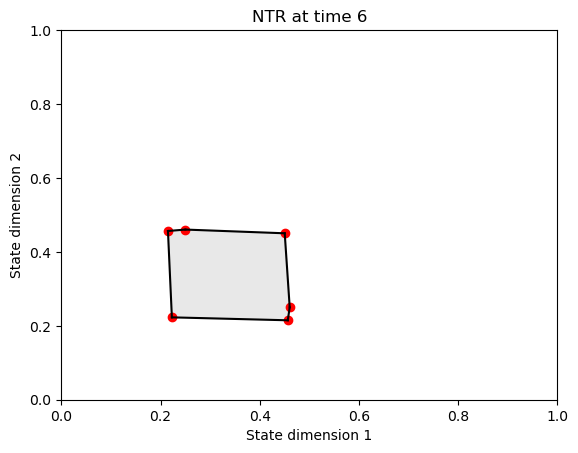

In [16]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def plot_ntr_at_time(NTR_history, t):
    hull = NTR_history[t]
    
    if hull is not None:
        vertices = hull.points  # Vertices are stored in the 'points' attribute of ConvexHull
        D = vertices.shape[1]  # Dimension of the state space
        plt.figure()

        if D == 2:
            # 2D plot
            for simplex in hull.simplices:
                plt.plot(vertices[simplex, 0], vertices[simplex, 1], 'k-')
            plt.fill(vertices[hull.vertices, 0], vertices[hull.vertices, 1], 'lightgray', alpha=0.5)
            plt.scatter(vertices[:, 0], vertices[:, 1], color='red')  # Plot the vertices
            plt.title(f'NTR at time {t}')
            plt.xlabel('State dimension 1')
            plt.ylabel('State dimension 2')
            plt.xlim(0, 1)
            plt.ylim(0, 1)
        
        elif D == 3:
            # 3D plot
            ax = plt.axes(projection='3d')
            ax.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2], color='red')
            ax.add_collection3d(Poly3DCollection(vertices[hull.simplices], facecolors='lightgray', edgecolors='k', alpha=0.4))
            ax.set_xlabel('State dimension 1')
            ax.set_ylabel('State dimension 2')
            ax.set_zlabel('State dimension 3')
            plt.title(f'NTR at time {t}')
            ax.set_xlim(0, 1)
            ax.set_ylim(0, 1)
            ax.set_zlim(0, 1)
        
        plt.show()

    else:
        print(f"Not enough vertices to form an NTR at time {t}")

# Example: Plot NTR at time t=1
plot_ntr_at_time(NTRs, T-2)